# Sunspots forecasting with SARIMA

## Source of the data 
* The data comes from http://www.sidc.be/
* A full description can be found here http://www.sidc.be/silso/infosndtot

**The data gather the daily total sunspot number from 1818.**

In [1]:
# Import librairies
%matplotlib inline 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers

## Description of the data 
Columns are :
* Year
* Month
* Day
* Fraction of the year
* Total sunspot number
* Standard deviation
* Number of observations
* Indicator : observation has been done or not.

**(-1) stands for NAN**

Daily total sunspot number derived by the formula: R= Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk.

In [2]:
# load the data
path = "./kaggle/input/daily-sun-spot-data-1818-to-2019/"
filename = os.path.join(path,"sunspot_data.csv")
df = pd.read_csv('/kaggle/input/daily-sun-spot-data-1818-to-2019/sunspot_data.csv', delimiter=',', na_values=['-1'])
df.dataframeName = 'sunspot_data.csv'
del(df['Unnamed: 0'])
df.columns = ['year', 'month', 'day', 'fraction','sunspots', 'sdt', 'obs','indicator']
df.head(-5)

# Add the column time 
df['time']=df[['year', 'month', 'day']].apply(lambda s: pd.datetime(*s),axis = 1)
# time column is the index of the dataframe
df.index = df['time']
# replace the Nan by linear interpolation 
df['sunspots'].interpolate(method='linear', inplace=True)

# SARIMA - Seasonal Autoregressive Integrated Moving Average
SARIMA is a seasonal ARIMA

In order to configure a SARIMA(p,d,q)(P,D,Q)S, two kind of hyperparameters have to be set 

#### Trend parameters
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.(The purpose of differencing it to make the time series stationary.)
* q: The size of the moving average window, also called the order of moving average.
(The purpose of differencing it to make the time series stationary.)

#### Seasonal parameters
* P: Seasonal autoregressive order.
* D: Seasonal order of differencing.
* Q: Seasonal moving average order.
* S: The number of time steps for a single seasonal period.




## Running SARIMA
First plot PACF and ACF

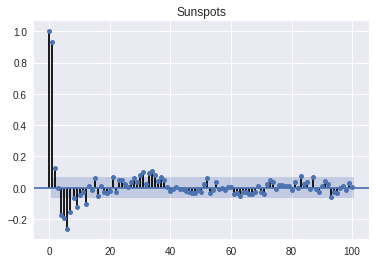

In [4]:
plot_pacf(ts_quarter,lags=100,title='Sunspots')
plt.show()

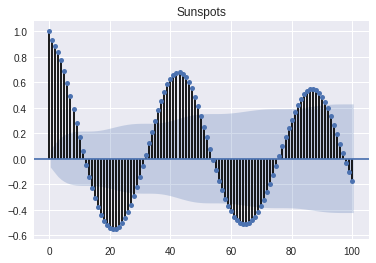

In [5]:
plot_acf(ts_quarter,lags=100,title='Sunspots')
plt.show()

### Finding the order of differencing (d)
The test of stationarity is significative with non differencing, so d=0

In [6]:
from statsmodels.tsa.stattools import adfuller
def printADFTest(serie):
    result = adfuller(serie, autolag='AIC')
    print("ADF Statistic %F" % (result[0]))
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print('\n')

#d = 0
printADFTest(ts_quarter)
#d = 1 
#printADFTest(ts_quarter.diff(1).dropna())

ADF Statistic -9.778954
p-value: 6.814515890287653e-17
Critial Values:
   1%, -3.4385918508847646
Critial Values:
   5%, -2.865177791819505
Critial Values:
   10%, -2.568707096601096




### Find the seasonality (S) ?
https://en.wikipedia.org/wiki/Solar_cycle
> The solar cycle or solar magnetic activity cycle is a nearly periodic 11-year change in the Sun's activity. 

From the ACF plot, the first high lag is around 43, so let's take **S=43**

## Build the model SARIMA(3,0,10)(1,1,0,43)

In [7]:
model = sm.tsa.statespace.SARIMAX(ts_quarter, trend='n', order=(3,0,10), seasonal_order=(1,1,0,43))
results = model.fit()
print(results.summary())


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                  Statespace Model Results                                 
Dep. Variable:                            sunspots   No. Observations:                  808
Model:             SARIMAX(3, 0, 10)x(1, 1, 0, 43)   Log Likelihood               -3584.094
Date:                             Mon, 30 Dec 2019   AIC                           7198.189
Time:                                     16:47:55   BIC                           7267.787
Sample:                                 03-31-1818   HQIC                          7224.982
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8983      0.130      6.925      0.000       0.644       1.153
ar.L2          0.7610      

## Plot the forecast

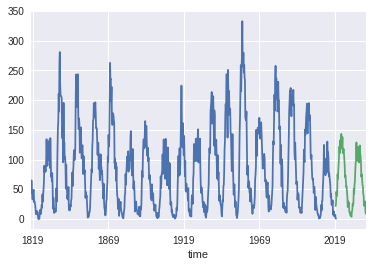

In [8]:
forecast = results.predict(start = ts_quarter.index[-2], end= ts_quarter.index[-2] + pd.DateOffset(months=240), dynamic= True) 
ts_quarter.plot()
forecast.plot()
plt.show()


## Determining the parameters (p,d,q)(P,D,Q,S) with a grid search
We need to install the package pmdarima

In [9]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 


In [10]:
import pmdarima as pm
grid_model = pm.auto_arima(ts_quarter, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4, m=43,
                         start_P=0, seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print(grid_model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 43); AIC=7073.414, BIC=7096.613, Fit time=49.045 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 43); AIC=8208.763, BIC=8218.043, Fit time=0.659 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 43); AIC=7276.482, BIC=7295.041, Fit time=31.872 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 43); AIC=7658.896, BIC=7677.456, Fit time=39.918 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 43); AIC=8206.906, BIC=8211.546, Fit time=0.468 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 43); AIC=7392.616, BIC=7411.175, Fit time=5.267 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 43); AIC=7071.398, BIC=7099.238, Fit time=118.086 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 43); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 43); AIC=7071.401, BIC=7099.

### plot the forecast

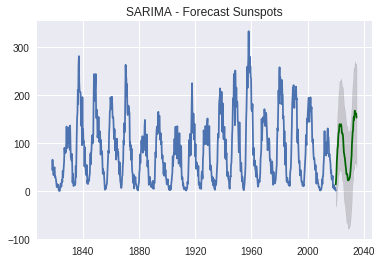

In [11]:
period = 60
fitted, confint = grid_model.predict(n_periods=period, return_conf_int=True)
index_of_fc = pd.date_range(ts_quarter.index[-1], periods = period, freq='Q')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(ts_quarter)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast Sunspots")
plt.show()